Setup completato!
Environment pronto
Agente SARSA pronto
Training SARSA: 500000 episodi...


  1%|▏         | 7403/500000 [00:00<00:06, 74019.13it/s]


Ep 5000: Avg Reward=-0.249, WinRate=0.347, Eps=0.6065

Ep 10000: Avg Reward=-0.188, WinRate=0.360, Eps=0.3679

Ep 15000: Avg Reward=-0.163, WinRate=0.368, Eps=0.2231


  3%|▎         | 15837/500000 [00:00<00:06, 80083.96it/s]


Ep 20000: Avg Reward=-0.126, WinRate=0.375, Eps=0.1353

  6%|▋         | 31520/500000 [00:00<00:06, 76394.57it/s]



Ep 25000: Avg Reward=-0.105, WinRate=0.381, Eps=0.0821

Ep 30000: Avg Reward=-0.085, WinRate=0.386, Eps=0.0498

Ep 35000: Avg Reward=-0.091, WinRate=0.390, Eps=0.0302


 11%|█         | 54273/500000 [00:00<00:05, 74872.75it/s]


Ep 40000: Avg Reward=-0.056, WinRate=0.395, Eps=0.0183

Ep 45000: Avg Reward=-0.064, WinRate=0.398, Eps=0.0111

Ep 50000: Avg Reward=-0.049, WinRate=0.401, Eps=0.0100

Ep 55000: Avg Reward=-0.066, WinRate=0.403, Eps=0.0100


 14%|█▍        | 69172/500000 [00:00<00:05, 73909.36it/s]


Ep 60000: Avg Reward=-0.062, WinRate=0.405, Eps=0.0100

Ep 65000: Avg Reward=-0.075, WinRate=0.406, Eps=0.0100

Ep 70000: Avg Reward=-0.073, WinRate=0.407, Eps=0.0100

Ep 75000: Avg Reward=-0.083, WinRate=0.407, Eps=0.0100


 18%|█▊        | 91272/500000 [00:01<00:05, 71072.66it/s]


Ep 80000: Avg Reward=-0.083, WinRate=0.407, Eps=0.0100

Ep 85000: Avg Reward=-0.081, WinRate=0.408, Eps=0.0100

Ep 90000: Avg Reward=-0.074, WinRate=0.408, Eps=0.0100


 21%|██        | 105983/500000 [00:01<00:05, 72289.00it/s]


Ep 95000: Avg Reward=-0.067, WinRate=0.409, Eps=0.0100

Ep 100000: Avg Reward=-0.056, WinRate=0.410, Eps=0.0100

Ep 105000: Avg Reward=-0.071, WinRate=0.410, Eps=0.0100

Ep 110000: Avg Reward=-0.075, WinRate=0.411, Eps=0.0100


 26%|██▌       | 127866/500000 [00:01<00:05, 71958.62it/s]


Ep 115000: Avg Reward=-0.069, WinRate=0.411, Eps=0.0100

Ep 120000: Avg Reward=-0.076, WinRate=0.411, Eps=0.0100

Ep 125000: Avg Reward=-0.070, WinRate=0.411, Eps=0.0100

Ep 130000: Avg Reward=-0.067, WinRate=0.412, Eps=0.0100


 30%|███       | 150000/500000 [00:02<00:04, 73215.25it/s]


Ep 135000: Avg Reward=-0.065, WinRate=0.412, Eps=0.0100

Ep 140000: Avg Reward=-0.070, WinRate=0.412, Eps=0.0100

Ep 145000: Avg Reward=-0.052, WinRate=0.413, Eps=0.0100

Ep 150000: Avg Reward=-0.056, WinRate=0.413, Eps=0.0100


 33%|███▎      | 164543/500000 [00:02<00:04, 67154.32it/s]


Ep 155000: Avg Reward=-0.056, WinRate=0.414, Eps=0.0100

Ep 160000: Avg Reward=-0.084, WinRate=0.413, Eps=0.0100

Ep 165000: Avg Reward=-0.061, WinRate=0.414, Eps=0.0100


 36%|███▌      | 178996/500000 [00:02<00:04, 69869.20it/s]


Ep 170000: Avg Reward=-0.055, WinRate=0.414, Eps=0.0100

Ep 175000: Avg Reward=-0.062, WinRate=0.414, Eps=0.0100

Ep 180000: Avg Reward=-0.038, WinRate=0.415, Eps=0.0100

Ep 185000: Avg Reward=-0.066, WinRate=0.415, Eps=0.0100


 40%|████      | 200518/500000 [00:02<00:04, 69882.67it/s]


Ep 190000: Avg Reward=-0.045, WinRate=0.415, Eps=0.0100

Ep 195000: Avg Reward=-0.072, WinRate=0.415, Eps=0.0100

Ep 200000: Avg Reward=-0.053, WinRate=0.415, Eps=0.0100


 43%|████▎     | 215268/500000 [00:02<00:03, 71946.02it/s]


Ep 205000: Avg Reward=-0.066, WinRate=0.416, Eps=0.0100

Ep 210000: Avg Reward=-0.044, WinRate=0.416, Eps=0.0100

Ep 215000: Avg Reward=-0.060, WinRate=0.416, Eps=0.0100

Ep 220000: Avg Reward=-0.051, WinRate=0.416, Eps=0.0100


 47%|████▋     | 237227/500000 [00:03<00:03, 67865.31it/s]


Ep 225000: Avg Reward=-0.071, WinRate=0.416, Eps=0.0100

Ep 230000: Avg Reward=-0.057, WinRate=0.417, Eps=0.0100

Ep 235000: Avg Reward=-0.052, WinRate=0.417, Eps=0.0100


 50%|█████     | 251722/500000 [00:03<00:03, 70253.09it/s]


Ep 240000: Avg Reward=-0.054, WinRate=0.417, Eps=0.0100

Ep 245000: Avg Reward=-0.069, WinRate=0.417, Eps=0.0100

Ep 250000: Avg Reward=-0.084, WinRate=0.417, Eps=0.0100

Ep 255000: Avg Reward=-0.050, WinRate=0.417, Eps=0.0100


 55%|█████▍    | 273256/500000 [00:03<00:03, 71184.66it/s]


Ep 260000: Avg Reward=-0.038, WinRate=0.417, Eps=0.0100

Ep 265000: Avg Reward=-0.041, WinRate=0.417, Eps=0.0100

Ep 270000: Avg Reward=-0.083, WinRate=0.417, Eps=0.0100

Ep 275000: Avg Reward=-0.052, WinRate=0.418, Eps=0.0100


 59%|█████▉    | 295246/500000 [00:04<00:02, 72771.54it/s]


Ep 280000: Avg Reward=-0.058, WinRate=0.418, Eps=0.0100

Ep 285000: Avg Reward=-0.068, WinRate=0.418, Eps=0.0100

Ep 290000: Avg Reward=-0.033, WinRate=0.418, Eps=0.0100

Ep 295000: Avg Reward=-0.042, WinRate=0.418, Eps=0.0100


 62%|██████▏   | 309895/500000 [00:04<00:02, 68130.79it/s]


Ep 300000: Avg Reward=-0.049, WinRate=0.419, Eps=0.0100

Ep 305000: Avg Reward=-0.062, WinRate=0.419, Eps=0.0100

Ep 310000: Avg Reward=-0.053, WinRate=0.419, Eps=0.0100


 65%|██████▍   | 324477/500000 [00:04<00:02, 70583.92it/s]


Ep 315000: Avg Reward=-0.065, WinRate=0.419, Eps=0.0100

Ep 320000: Avg Reward=-0.052, WinRate=0.419, Eps=0.0100

Ep 325000: Avg Reward=-0.069, WinRate=0.419, Eps=0.0100

Ep 330000: Avg Reward=-0.067, WinRate=0.419, Eps=0.0100


 69%|██████▉   | 345987/500000 [00:04<00:02, 66255.94it/s]


Ep 335000: Avg Reward=-0.067, WinRate=0.419, Eps=0.0100

Ep 340000: Avg Reward=-0.067, WinRate=0.419, Eps=0.0100

Ep 345000: Avg Reward=-0.052, WinRate=0.419, Eps=0.0100


 71%|███████   | 352683/500000 [00:05<00:02, 52947.27it/s]


Ep 350000: Avg Reward=-0.063, WinRate=0.419, Eps=0.0100

Ep 355000: Avg Reward=-0.074, WinRate=0.419, Eps=0.0100


 73%|███████▎  | 363515/500000 [00:05<00:03, 43078.02it/s]


Ep 360000: Avg Reward=-0.062, WinRate=0.419, Eps=0.0100

Ep 365000: Avg Reward=-0.027, WinRate=0.419, Eps=0.0100


 75%|███████▌  | 376753/500000 [00:05<00:03, 40929.14it/s]


Ep 370000: Avg Reward=-0.043, WinRate=0.420, Eps=0.0100

Ep 375000: Avg Reward=-0.040, WinRate=0.420, Eps=0.0100


 77%|███████▋  | 384944/500000 [00:05<00:02, 39803.74it/s]


Ep 380000: Avg Reward=-0.061, WinRate=0.420, Eps=0.0100

Ep 385000: Avg Reward=-0.089, WinRate=0.420, Eps=0.0100


 79%|███████▉  | 396907/500000 [00:06<00:02, 39464.63it/s]


Ep 390000: Avg Reward=-0.054, WinRate=0.420, Eps=0.0100

Ep 395000: Avg Reward=-0.085, WinRate=0.420, Eps=0.0100


 81%|████████  | 404902/500000 [00:06<00:02, 39639.80it/s]


Ep 400000: Avg Reward=-0.052, WinRate=0.420, Eps=0.0100

Ep 405000: Avg Reward=-0.061, WinRate=0.420, Eps=0.0100


 83%|████████▎ | 416917/500000 [00:06<00:02, 39402.95it/s]


Ep 410000: Avg Reward=-0.046, WinRate=0.420, Eps=0.0100

Ep 415000: Avg Reward=-0.061, WinRate=0.420, Eps=0.0100


 85%|████████▍ | 424905/500000 [00:06<00:01, 39623.81it/s]


Ep 420000: Avg Reward=-0.047, WinRate=0.420, Eps=0.0100

Ep 425000: Avg Reward=-0.038, WinRate=0.420, Eps=0.0100


 87%|████████▋ | 437067/500000 [00:07<00:01, 40117.71it/s]


Ep 430000: Avg Reward=-0.072, WinRate=0.420, Eps=0.0100

Ep 435000: Avg Reward=-0.055, WinRate=0.420, Eps=0.0100


 89%|████████▉ | 445026/500000 [00:07<00:01, 39241.75it/s]


Ep 440000: Avg Reward=-0.062, WinRate=0.420, Eps=0.0100

Ep 445000: Avg Reward=-0.024, WinRate=0.420, Eps=0.0100


 91%|█████████▏| 456831/500000 [00:07<00:01, 38766.98it/s]


Ep 450000: Avg Reward=-0.060, WinRate=0.421, Eps=0.0100

Ep 455000: Avg Reward=-0.072, WinRate=0.420, Eps=0.0100


 93%|█████████▎| 464639/500000 [00:07<00:00, 38072.64it/s]


Ep 460000: Avg Reward=-0.050, WinRate=0.421, Eps=0.0100

Ep 465000: Avg Reward=-0.049, WinRate=0.421, Eps=0.0100


 95%|█████████▌| 476205/500000 [00:08<00:00, 37819.63it/s]


Ep 470000: Avg Reward=-0.046, WinRate=0.421, Eps=0.0100

Ep 475000: Avg Reward=-0.033, WinRate=0.421, Eps=0.0100

Ep 480000: Avg Reward=-0.038, WinRate=0.421, Eps=0.0100


100%|██████████| 500000/500000 [00:08<00:00, 58119.95it/s]


Ep 485000: Avg Reward=-0.053, WinRate=0.421, Eps=0.0100

Ep 490000: Avg Reward=-0.055, WinRate=0.421, Eps=0.0100

Ep 495000: Avg Reward=-0.063, WinRate=0.421, Eps=0.0100

Ep 500000: Avg Reward=-0.047, WinRate=0.421, Eps=0.0100



✓ Training completato!
  Q-table: 280 stati
  Win rate: 0.4213

Evaluation su 500000 episodi...


100%|██████████| 500000/500000 [00:05<00:00, 89970.02it/s]



Risultati:
  Win Rate:  0.4267
  Loss Rate: 0.4790
  Draw Rate: 0.0943
  Avg Reward: -0.0523


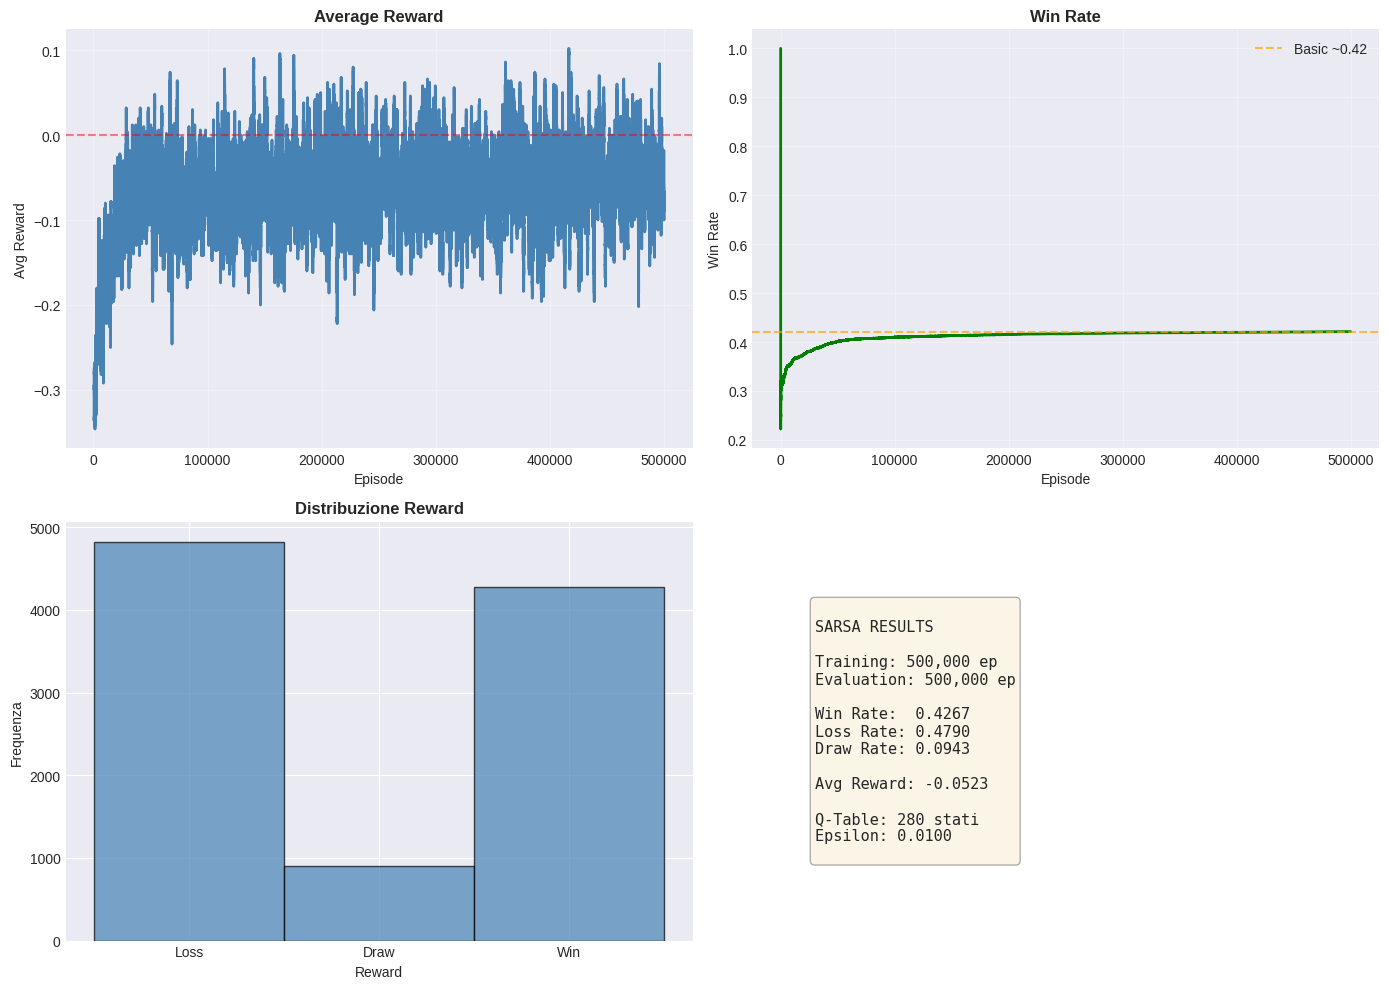

✓ Grafici creati!


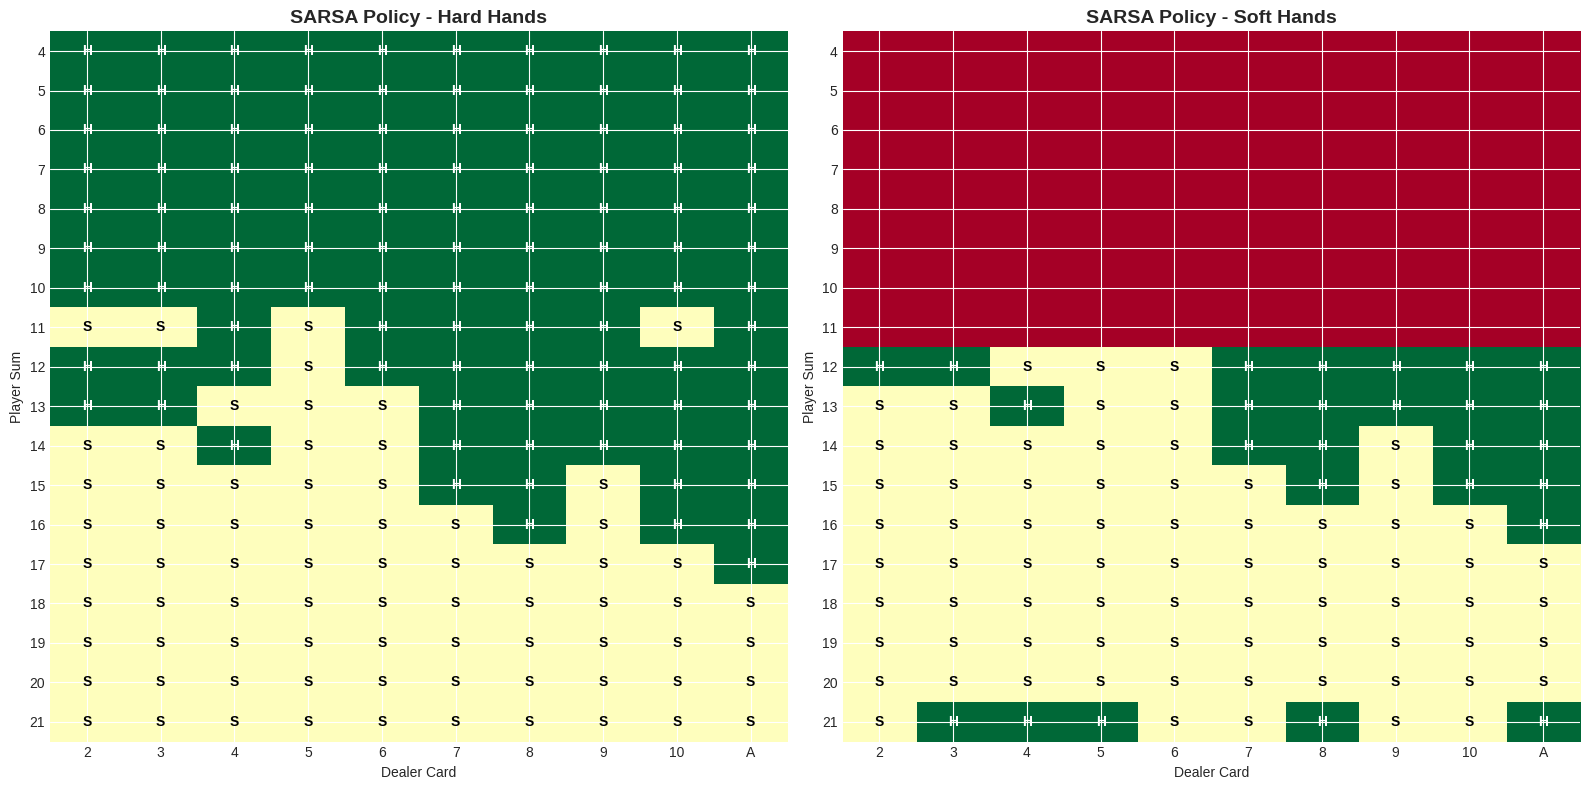

✓ Policy creata!


In [2]:
# Setup
!pip install -q pandas numpy matplotlib seaborn tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from collections import defaultdict
from tqdm import tqdm
import pickle
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("Setup completato!")

# Blackjack Environment
class BlackjackEnv:
    def __init__(self, num_decks=8):
        self.num_decks = num_decks
        self.reset_deck()

    def reset_deck(self):
        deck = []
        for _ in range(self.num_decks):
            for _ in range(4):
                deck.extend([11] + list(range(2, 11)) + [10, 10, 10])
        random.shuffle(deck)
        self.deck = deck

    def draw_card(self):
        if len(self.deck) < 20:
            self.reset_deck()
        return self.deck.pop()

    def get_hand_value(self, hand):
        value = sum(hand)
        aces = hand.count(11)
        while value > 21 and aces > 0:
            value -= 10
            aces -= 1
        is_soft = (aces > 0 and value <= 21)
        return value, is_soft

    def is_bust(self, hand):
        value, _ = self.get_hand_value(hand)
        return value > 21

    def dealer_play(self, dealer_hand):
        while True:
            value, is_soft = self.get_hand_value(dealer_hand)
            if value > 21:
                break
            if value >= 17 and not is_soft:
                break
            if value == 17 and is_soft:
                dealer_hand.append(self.draw_card())
            elif value < 17:
                dealer_hand.append(self.draw_card())
            else:
                break
        return dealer_hand

    def reset(self):
        player_hand = [self.draw_card(), self.draw_card()]
        dealer_hand = [self.draw_card(), self.draw_card()]
        return {
            'player_hand': player_hand,
            'dealer_hand': dealer_hand,
            'dealer_showing': dealer_hand[0]
        }

    def step(self, state, action):
        player_hand = state['player_hand'].copy()
        dealer_hand = state['dealer_hand'].copy()
        dealer_showing = state['dealer_showing']
        done = False
        reward = 0
        info = {}

        if action == 1:  # HIT
            player_hand.append(self.draw_card())
            if self.is_bust(player_hand):
                reward = -1
                done = True
                info['outcome'] = 'player_bust'
            else:
                return {
                    'player_hand': player_hand,
                    'dealer_hand': dealer_hand,
                    'dealer_showing': dealer_showing
                }, reward, done, info

        elif action == 0:  # STAND
            done = True
            dealer_hand = self.dealer_play(dealer_hand)
            player_value, _ = self.get_hand_value(player_hand)
            dealer_value, _ = self.get_hand_value(dealer_hand)

            if self.is_bust(dealer_hand):
                reward = 1
                info['outcome'] = 'dealer_bust'
            elif player_value > dealer_value:
                reward = 1
                info['outcome'] = 'player_wins'
            elif player_value < dealer_value:
                reward = -1
                info['outcome'] = 'dealer_wins'
            else:
                reward = 0
                info['outcome'] = 'push'

        return {
            'player_hand': player_hand,
            'dealer_hand': dealer_hand,
            'dealer_showing': dealer_showing
        }, reward, done, info

print("Environment pronto")
# SARSA Agent
def state_to_tuple(state, env):
    player_value, is_soft = env.get_hand_value(state['player_hand'])
    return (player_value, int(is_soft), state['dealer_showing'])

class SARSAAgent:
    def __init__(self, learning_rate=0.1, discount_factor=0.95,
                 epsilon=1.0, epsilon_decay=0.9999, epsilon_min=0.01):
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.q_table = defaultdict(lambda: defaultdict(float))
        self.episode_rewards = []
        self.wins = 0
        self.losses = 0
        self.draws = 0

    def get_best_action(self, state, env):
        state_key = state_to_tuple(state, env)
        if state_key not in self.q_table:
            return random.choice([0, 1])
        q_values = self.q_table[state_key]
        if not q_values:
            return random.choice([0, 1])
        max_q = max(q_values.values())
        best_actions = [a for a, q in q_values.items() if q == max_q]
        return random.choice(best_actions)

    def choose_action(self, state, env, training=True):
        player_value, _ = env.get_hand_value(state['player_hand'])
        if player_value >= 21:
            return 0
        if training and random.random() < self.epsilon:
            return random.choice([0, 1])
        else:
            return self.get_best_action(state, env)

    def update_q_value(self, state, action, reward, next_state, next_action, env):
        state_key = state_to_tuple(state, env)
        next_state_key = state_to_tuple(next_state, env)
        current_q = self.q_table[state_key][action]
        next_q = self.q_table[next_state_key][next_action]
        new_q = current_q + self.lr * (reward + self.gamma * next_q - current_q)
        self.q_table[state_key][action] = new_q

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def train(self, env, num_episodes=50000, verbose_every=5000):
        print(f"Training SARSA: {num_episodes} episodi...")
        for episode in tqdm(range(num_episodes)):
            state = env.reset()
            action = self.choose_action(state, env, training=True)
            done = False
            episode_reward = 0
            steps = 0

            while not done and steps < 50:
                next_state, reward, done, info = env.step(state, action)

                if done:
                    state_key = state_to_tuple(state, env)
                    current_q = self.q_table[state_key][action]
                    new_q = current_q + self.lr * (reward - current_q)
                    self.q_table[state_key][action] = new_q
                else:
                    next_action = self.choose_action(next_state, env, training=True)
                    self.update_q_value(state, action, reward, next_state, next_action, env)
                    state = next_state
                    action = next_action

                episode_reward += reward
                steps += 1

            self.episode_rewards.append(episode_reward)
            if episode_reward > 0:
                self.wins += 1
            elif episode_reward < 0:
                self.losses += 1
            else:
                self.draws += 1

            self.decay_epsilon()

            if (episode + 1) % verbose_every == 0:
                recent_rewards = self.episode_rewards[-verbose_every:]
                avg_reward = np.mean(recent_rewards)
                win_rate = self.wins / (episode + 1)
                print(f"\nEp {episode + 1}: Avg Reward={avg_reward:.3f}, WinRate={win_rate:.3f}, Eps={self.epsilon:.4f}")

        print(f"\n✓ Training completato!")
        print(f"  Q-table: {len(self.q_table)} stati")
        print(f"  Win rate: {self.wins / num_episodes:.4f}")

    def evaluate(self, env, num_episodes=10000):
        print(f"\nEvaluation su {num_episodes} episodi...")
        wins = 0
        losses = 0
        draws = 0
        total_reward = 0

        for episode in tqdm(range(num_episodes)):
            state = env.reset()
            done = False
            episode_reward = 0
            steps = 0

            while not done and steps < 50:
                action = self.choose_action(state, env, training=False)
                state, reward, done, info = env.step(state, action)
                episode_reward += reward
                steps += 1

            total_reward += episode_reward
            if episode_reward > 0:
                wins += 1
            elif episode_reward < 0:
                losses += 1
            else:
                draws += 1

        win_rate = wins / num_episodes
        loss_rate = losses / num_episodes
        draw_rate = draws / num_episodes
        avg_reward = total_reward / num_episodes

        print(f"\nRisultati:")
        print(f"  Win Rate:  {win_rate:.4f}")
        print(f"  Loss Rate: {loss_rate:.4f}")
        print(f"  Draw Rate: {draw_rate:.4f}")
        print(f"  Avg Reward: {avg_reward:.4f}")

        return {'win_rate': win_rate, 'loss_rate': loss_rate, 'draw_rate': draw_rate, 'avg_reward': avg_reward}

print("Agente SARSA pronto")

# Training
env_train = BlackjackEnv(num_decks=8)
sarsa_agent = SARSAAgent(
    learning_rate=0.01,
    discount_factor=0.95,
    epsilon=1.0,
    epsilon_decay=0.9999,
    epsilon_min=0.01
)

sarsa_agent.train(env_train, num_episodes=500000, verbose_every=5000)

# Valutazione
env_eval = BlackjackEnv(num_decks=8)
results_sarsa = sarsa_agent.evaluate(env_eval, num_episodes=500000)

# Visualizzazioni
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Reward
window = 500
rewards_smooth = pd.Series(sarsa_agent.episode_rewards).rolling(window=window).mean()
axes[0, 0].plot(rewards_smooth, color='steelblue', linewidth=2)
axes[0, 0].set_title('Average Reward', fontweight='bold')
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Avg Reward')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)

# 2. Win rate
wins_cumulative = np.cumsum([1 if r > 0 else 0 for r in sarsa_agent.episode_rewards])
episodes = np.arange(1, len(sarsa_agent.episode_rewards) + 1)
win_rates = wins_cumulative / episodes
axes[0, 1].plot(win_rates, color='green', linewidth=2)
axes[0, 1].set_title('Win Rate', fontweight='bold')
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('Win Rate')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axhline(y=0.42, color='orange', linestyle='--', label='Basic ~0.42', alpha=0.7)
axes[0, 1].legend()

# 3. Distribuzione
recent = sarsa_agent.episode_rewards[-10000:]
axes[1, 0].hist(recent, bins=[-1.5, -0.5, 0.5, 1.5], color='steelblue', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Distribuzione Reward', fontweight='bold')
axes[1, 0].set_xlabel('Reward')
axes[1, 0].set_ylabel('Frequenza')
axes[1, 0].set_xticks([-1, 0, 1])
axes[1, 0].set_xticklabels(['Loss', 'Draw', 'Win'])

# 4. Stats
axes[1, 1].axis('off')
stats = f"""
SARSA RESULTS

Training: {len(sarsa_agent.episode_rewards):,} ep
Evaluation: 500,000 ep

Win Rate:  {results_sarsa['win_rate']:.4f}
Loss Rate: {results_sarsa['loss_rate']:.4f}
Draw Rate: {results_sarsa['draw_rate']:.4f}

Avg Reward: {results_sarsa['avg_reward']:.4f}

Q-Table: {len(sarsa_agent.q_table):,} stati
Epsilon: {sarsa_agent.epsilon:.4f}
"""
axes[1, 1].text(0.1, 0.5, stats, fontsize=11, family='monospace',
               verticalalignment='center',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.savefig('sarsa_results.png', dpi=200, bbox_inches='tight')
plt.show()

print("Grafici creati!")

# Policy Heatmap
player_sums = range(4, 22)
dealer_cards = range(2, 12)

policy_matrix_hard = np.zeros((len(player_sums), len(dealer_cards)))
policy_matrix_soft = np.zeros((len(player_sums), len(dealer_cards)))

for i, ps in enumerate(player_sums):
    for j, dc in enumerate(dealer_cards):
        # Hard
        state_hard = {'player_hand': [ps], 'dealer_hand': [dc, 0], 'dealer_showing': dc}
        state_key_hard = (ps, 0, dc)
        if state_key_hard in sarsa_agent.q_table:
            action = sarsa_agent.get_best_action(state_hard, env_eval)
            policy_matrix_hard[i, j] = action
        else:
            policy_matrix_hard[i, j] = -1

        # Soft
        state_soft = {'player_hand': [ps, 11], 'dealer_hand': [dc, 0], 'dealer_showing': dc}
        state_key_soft = (ps, 1, dc)
        if state_key_soft in sarsa_agent.q_table:
            action = sarsa_agent.get_best_action(state_soft, env_eval)
            policy_matrix_soft[i, j] = action
        else:
            policy_matrix_soft[i, j] = -1

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Hard
axes[0].imshow(policy_matrix_hard, cmap='RdYlGn', aspect='auto', vmin=-1, vmax=1)
axes[0].set_title('SARSA Policy - Hard Hands', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Dealer Card')
axes[0].set_ylabel('Player Sum')
axes[0].set_xticks(range(len(dealer_cards)))
axes[0].set_xticklabels([str(dc) if dc < 11 else 'A' for dc in dealer_cards])
axes[0].set_yticks(range(len(player_sums)))
axes[0].set_yticklabels(player_sums)

for i in range(len(player_sums)):
    for j in range(len(dealer_cards)):
        if policy_matrix_hard[i, j] == 1:
            axes[0].text(j, i, 'H', ha='center', va='center', color='white', fontweight='bold')
        elif policy_matrix_hard[i, j] == 0:
            axes[0].text(j, i, 'S', ha='center', va='center', color='black', fontweight='bold')

# Soft
axes[1].imshow(policy_matrix_soft, cmap='RdYlGn', aspect='auto', vmin=-1, vmax=1)
axes[1].set_title('SARSA Policy - Soft Hands', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Dealer Card')
axes[1].set_ylabel('Player Sum')
axes[1].set_xticks(range(len(dealer_cards)))
axes[1].set_xticklabels([str(dc) if dc < 11 else 'A' for dc in dealer_cards])
axes[1].set_yticks(range(len(player_sums)))
axes[1].set_yticklabels(player_sums)

for i in range(len(player_sums)):
    for j in range(len(dealer_cards)):
        if policy_matrix_soft[i, j] == 1:
            axes[1].text(j, i, 'H', ha='center', va='center', color='white', fontweight='bold')
        elif policy_matrix_soft[i, j] == 0:
            axes[1].text(j, i, 'S', ha='center', va='center', color='black', fontweight='bold')

plt.tight_layout()
plt.savefig('sarsa_policy.png', dpi=200, bbox_inches='tight')
plt.show()

print("Policy creata!")